In [2]:
from string import ascii_lowercase

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

import analysis
import plotting

matplotib = plotting.plot_utils.set_mpl_defaults(matplotlib)

from os.path import join

In [3]:
# Load trial data
# Load choiceshares (including RST)
trials = pd.read_csv(join("..", "results", "0-clean_data", "trials_with-dwells.csv"))
trials.head()

,subject,block,trial,effect,target,key,choice,choice_tcd,rt,pA,...,dwell_Ap,dwell_Am,dwell_Bp,dwell_Bm,dwell_Cp,dwell_Cm,dwell_total,dwell_target,dwell_competitor,dwell_decoy
0,0,1,1,attraction,A,M,A,target,7220.0,0.78,...,0.314554,0.251566,0.150857,0.039272,0.152557,0.091194,5296.395,0.566120,0.190129,0.243751
1,0,1,2,attraction,B,M,B,target,7770.0,0.78,...,0.071439,0.224211,0.155245,0.329696,0.163684,0.055725,6873.000,0.484941,0.295650,0.219409
2,0,1,3,attraction,A,M,C,decoy,5870.0,0.72,...,0.128630,0.165096,0.233418,0.130233,0.273690,0.068932,4991.041,0.293726,0.363652,0.342622
3,0,1,4,attraction,B,L,C,decoy,9550.0,0.78,...,0.095684,0.093789,0.151934,0.238737,0.221803,0.198053,8444.449,0.390671,0.189474,0.419856
4,0,1,5,filler,NaN,M,C,NaN,3740.0,0.29,...,0.000000,0.322605,0.000000,0.111408,0.327980,0.238007,3357.045,NaN,NaN,NaN


In [3]:
# Load choiceshares (including RST)
cs = pd.read_csv(
    join("..", "results", "1-behaviour", "choiceshares_across-targets.csv")
)
cs.head()

,subject,effect,A,B,C,competitor,decoy,target,rst
0,0,attraction,0.5000,0.4583,0.0417,0.1979,0.0417,0.7604,0.7935
1,0,compromise,0.4375,0.3229,0.2396,0.1875,0.2396,0.5729,0.7534
2,1,attraction,0.1667,0.8229,0.0104,0.4688,0.0104,0.5208,0.5263
3,1,compromise,0.1771,0.5833,0.2396,0.5208,0.2396,0.2396,0.3151
4,2,attraction,0.8125,0.1875,0.0000,0.5000,0.0000,0.5000,0.5000


In [4]:
# Load mean dwells
dw = pd.read_csv(join("..", "results", "2-gaze", "dwells_across-targets.csv"))
dw.head()

,subject,effect,dwell_A,dwell_B,dwell_C,dwell_p,dwell_m,dwell_target,dwell_competitor,dwell_decoy
0,0,attraction,0.3366,0.3523,0.3111,0.4923,0.5077,0.3818,0.3071,0.3111
1,0,compromise,0.3198,0.3627,0.3175,0.4960,0.5040,0.3651,0.3174,0.3175
2,1,attraction,0.2968,0.3954,0.3079,0.5297,0.4703,0.3508,0.3413,0.3079
3,1,compromise,0.3148,0.3758,0.3094,0.5483,0.4517,0.3471,0.3435,0.3094
4,2,attraction,0.3701,0.3508,0.2791,0.4855,0.5145,0.3507,0.3702,0.2791


In [5]:
# Load GLA estimates
est = pd.read_csv(
    join("..", "results", "3-behavioural-modeling", "estimates", "estimates_de1.csv"),
).drop("Unnamed: 0", axis=1)
gla = est.loc[
    est["model"] == "glickman1layer",
    ["subject", "nll", "bic", "alpha", "beta", "gamma", "lam", "theta"],
].reset_index(drop=True)
gla.head()

,subject,nll,bic,alpha,beta,gamma,lam,theta
0,0,100.209667,227.499835,0.440810,3.055906,0.563298,0.453037,0.512099
1,1,124.107191,275.294884,0.411877,0.705825,1.000000,0.082291,0.470740
2,2,75.038395,177.157292,0.129768,7.631085,1.000000,0.209830,0.832039
3,3,98.282816,223.646134,0.277980,26.315988,0.253684,0.287496,0.781941
4,4,158.310361,343.701224,0.378981,0.853402,1.000000,0.189743,0.463484


# 1. Does longer gaze to decoy relate to higher RST?

In [19]:
df = cs.merge(dw, on=["subject", "effect"])[
    ["subject", "effect", "rst", "dwell_target", "dwell_decoy"]
]
df.head()

,subject,effect,rst,dwell_target,dwell_decoy
0,0,attraction,0.7935,0.3818,0.3111
1,0,compromise,0.7534,0.3651,0.3175
2,1,attraction,0.5263,0.3508,0.3079
3,1,compromise,0.3151,0.3471,0.3094
4,2,attraction,0.5000,0.3507,0.2791


Attraction trials


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]
INFO:pymc3:NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Compromise trials


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]
INFO:pymc3:NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8929961371187392, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model ar

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


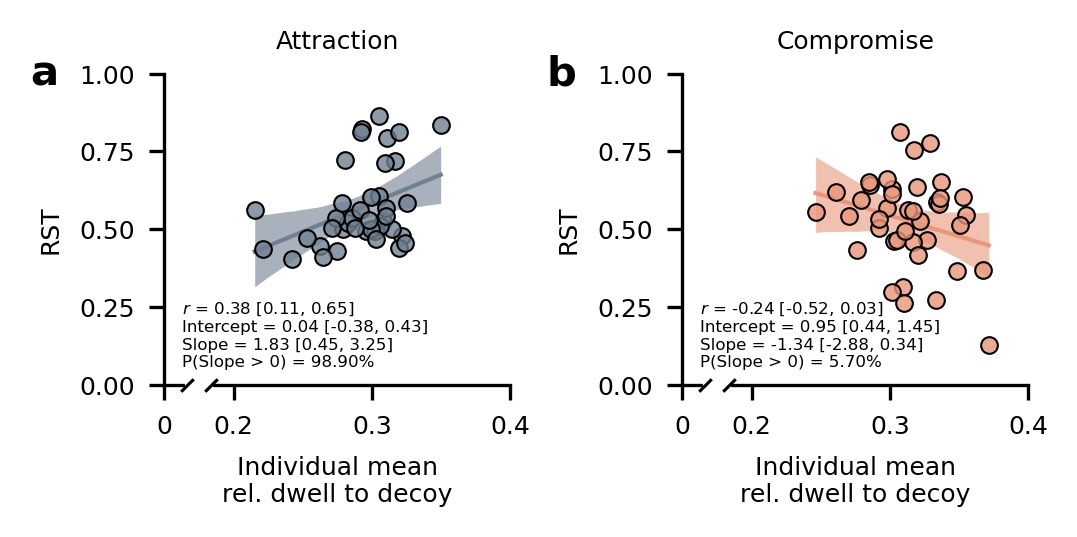

In [19]:
output = {}
fig, axs = plt.subplots(1, 2, figsize=(plotting.plot_utils.cm2inch((9, 4.5))))

colors = ["slategray", "darksalmon"]

for e, (effect, ax) in enumerate(zip(["attraction", "compromise"], axs)):
    print(effect.capitalize() + " trials")
    df_e = df.loc[df["effect"] == effect]

    output = plotting.plot_share.lm(
        x=df_e["dwell_decoy"],
        y=df_e["rst"],
        ax=ax,
        scatter_color=colors[e],
        line_color=colors[e],
        sample_kwargs={"cores": 1, "random_seed": 44},
    )
    ax, trace, summary = output

    summary.loc["x", "P>0"] = np.mean(trace.get_values("x") > 0)

    # Correlation analysis
    corr_trace = analysis.bayescorr.runBayesCorr(
        y1=df_e["dwell_decoy"],
        y2=df_e["rst"],
        sample_kwargs={"cores": 1, "random_seed": 44},
    )
    corr_summary = pm.summary(corr_trace, hdi_prob=0.95)

    stat_str = (
        "$r$"
        + f" = {corr_summary.loc['r', 'mean']:.2f} [{corr_summary.loc['r', 'hdi_2.5%']:.2f}, {corr_summary.loc['r', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Intercept = {summary.loc['Intercept', 'mean']:.2f} [{summary.loc['Intercept', 'hdi_2.5%']:.2f}, {summary.loc['Intercept', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Slope = {summary.loc['x', 'mean']:.2f} [{summary.loc['x', 'hdi_2.5%']:.2f}, {summary.loc['x', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"P(Slope > 0) = {100 * summary.loc['x', 'P>0']:.2f}%"
    )
    ax.annotate(
        stat_str,
        [0.05, 0.05],
        ha="left",
        va="bottom",
        fontsize=4,
        xycoords="axes fraction",
    )

    # Labels and limits
    ax.set_xlabel("Individual mean\nrel. dwell to decoy")
    ax.set_ylabel("RST")
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xlim(0.15, 0.4)
    ax.set_xticks([0.15, 0.2, 0.3, 0.4])
    ax.set_xticklabels([0, 0.2, 0.3, 0.4])
    ax.set_title(effect.capitalize())
    ax = plotting.plot_utils.break_after_nth_tick(ax, 0)

fig.tight_layout()

# Label panels
for ax, label in zip(axs, list(ascii_lowercase)):
    # Place axis labels in figure space, so that they are aligned
    # https://stackoverflow.com/a/52309638
    xshift = 0.1
    X = ax.get_position().x0
    Y = ax.get_position().y1
    fig.text(X - xshift, Y, label, size=10, weight="bold", ha="right", va="center")

plt.savefig(join("..", "figures", "S_dwell-to-decoy_rst.pdf"), bbox_inches="tight")

## 1.1 Individual level

Splitting trials into longer and shorter dwell to decoy, then calculating probability of choosing the target, and comparing.

In [31]:
# Add median dwell decoy for each subject and effect
trials = trials.merge(
    trials.groupby(["subject", "effect"], as_index=False)["dwell_decoy"]
    .quantile(0.5)
    .rename({"dwell_decoy": "median_dwell_decoy"}, axis=1),
    on=["subject", "effect"],
)
trials["dwell_decoy_split"] = np.where(
    trials["dwell_decoy"] <= trials["median_dwell_decoy"], "short", "long"
)
trials["target_chosen"] = trials["choice_tcd"] == "target"
trials.head()

,subject,block,trial,effect,target,key,choice,choice_tcd,rt,pA,...,dwell_Bm,dwell_Cp,dwell_Cm,dwell_total,dwell_target,dwell_competitor,dwell_decoy,median_dwell_decoy,dwell_decoy_split,target_chosen
0,0,1,1,attraction,A,M,A,target,7220.0,0.78,...,0.039272,0.152557,0.091194,5296.395,0.566120,0.190129,0.243751,0.320022,short,True
1,0,1,2,attraction,B,M,B,target,7770.0,0.78,...,0.329696,0.163684,0.055725,6873.000,0.484941,0.295650,0.219409,0.320022,short,True
2,0,1,3,attraction,A,M,C,decoy,5870.0,0.72,...,0.130233,0.273690,0.068932,4991.041,0.293726,0.363652,0.342622,0.320022,long,False
3,0,1,4,attraction,B,L,C,decoy,9550.0,0.78,...,0.238737,0.221803,0.198053,8444.449,0.390671,0.189474,0.419856,0.320022,long,False
4,0,1,17,attraction,B,M,C,decoy,6430.0,0.72,...,0.153818,0.136831,0.238377,5356.978,0.416466,0.208326,0.375207,0.320022,long,False


In [32]:
subject_means = (
    trials.loc[trials["effect"].isin(["attraction", "compromise"])]
    .groupby(["subject", "effect", "dwell_decoy_split"], as_index=False)[
        "target_chosen"
    ]
    .mean()
    .pivot_table(
        index=["subject", "effect"], values="target_chosen", columns="dwell_decoy_split"
    )
    .reset_index()
)
subject_means.head()

dwell_decoy_split,subject,effect,long,short
0,0,attraction,0.791667,0.729167
1,0,compromise,0.437500,0.708333
2,1,attraction,0.562500,0.479167
3,1,compromise,0.208333,0.270833
4,2,attraction,0.541667,0.458333


In [33]:
subject_means.groupby("effect").mean()

dwell_decoy_split,subject,long,short
effect,,,
attraction,20.6,0.621258,0.503223
compromise,20.6,0.342459,0.445312


In [88]:
for e, effect in enumerate(["attraction", "compromise"]):
    print(effect.capitalize())

    df_e = subject_means.loc[subject_means["effect"] == effect]

    trace = analysis.best.runBEST1G(
        df_e["long"] - df_e["short"],
        mu=0,
        sigma_low=0.0001,
        sample_kwargs={"cores": 1, "random_seed": 56},
    )

    summary_df = pm.summary(trace, hdi_prob=0.95)
    for var in ["mean", "difference", "d"]:
        summary_df.loc[var, "p>0"] = np.mean(trace.get_values(var) > 0)

    print(
        f"\tmean difference = {summary_df.loc['difference', 'mean']} [{summary_df.loc['difference', 'hdi_97.5%']}, {summary_df.loc['difference', 'hdi_2.5%']}]"
    )
    print(
        f"\td = {summary_df.loc['d', 'mean']} [{summary_df.loc['d', 'hdi_2.5%']}, {summary_df.loc['d', 'hdi_97.5%']}]"
    )

    print(
        "\t{}% of posterior mass above 0.".format(
            100 * np.mean(trace.get_values("d") > 0)
        )
    )

Attraction


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
/Users/felixmolter/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = 0.116 [0.141, 0.093]
	d = 1.777 [1.182, 2.448]
	100.0% of posterior mass above 0.
Compromise


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
/Users/felixmolter/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = -0.107 [-0.06, -0.152]
	d = -0.822 [-1.259, -0.382]
	0.0% of posterior mass above 0.


This was also very very significant.

# 2. Are gaze discount estimates from GLA related to RST?

In [34]:
df = cs.merge(gla, on=["subject"])[["subject", "effect", "rst", "theta"]]
df.head()

,subject,effect,rst,theta
0,0,attraction,0.7935,0.512099
1,0,compromise,0.7534,0.512099
2,1,attraction,0.5263,0.470740
3,1,compromise,0.3151,0.470740
4,2,attraction,0.5000,0.832039


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Attraction trials


Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/felixmolter/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Compromise trials


Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
/Users/felixmolter/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


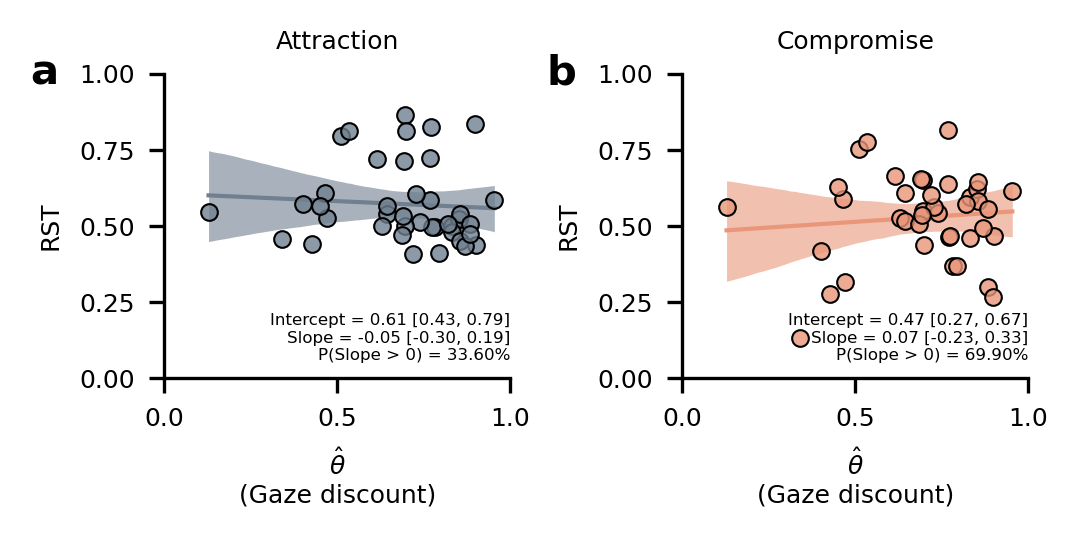

In [61]:
output = {}
fig, axs = plt.subplots(1, 2, figsize=(plotting.plot_utils.cm2inch((9, 4.5))))

colors = ["slategray", "darksalmon"]

for e, (effect, ax) in enumerate(zip(["attraction", "compromise"], axs)):
    print(effect.capitalize() + " trials")
    df_e = df.loc[df["effect"] == effect]

    output = plotting.plot_share.lm(
        x=df_e["theta"],
        y=df_e["rst"],
        ax=ax,
        scatter_color=colors[e],
        line_color=colors[e],
        sample_kwargs={"cores": 1, "random_seed": 44},
    )
    ax, trace, summary = output

    summary.loc["x", "P>0"] = np.mean(trace.get_values("x") > 0)

    stat_str = (
        f"Intercept = {summary.loc['Intercept', 'mean']:.2f} [{summary.loc['Intercept', 'hdi_2.5%']:.2f}, {summary.loc['Intercept', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Slope = {summary.loc['x', 'mean']:.2f} [{summary.loc['x', 'hdi_2.5%']:.2f}, {summary.loc['x', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"P(Slope > 0) = {100 * summary.loc['x', 'P>0']:.2f}%"
    )
    ax.annotate(
        stat_str,
        [1.0, 0.05],
        ha="right",
        va="bottom",
        fontsize=4,
        xycoords="axes fraction",
    )

    # Labels and limits
    ax.set_xlabel(r"$\hat{\theta}$" + "\n(Gaze discount)")
    ax.set_ylabel("RST")
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xlim(0.15, 0.4)
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_title(effect.capitalize())

fig.tight_layout()

# Label panels
for ax, label in zip(axs, list(ascii_lowercase)):
    # Place axis labels in figure space, so that they are aligned
    # https://stackoverflow.com/a/52309638
    xshift = 0.1
    X = ax.get_position().x0
    Y = ax.get_position().y1
    fig.text(X - xshift, Y, label, size=10, weight="bold", ha="right", va="center")

There is no relationship between gaze discounts and context effect strength.

# 3. Does dwell to decoy generally differ between attraction and compromise trials?

In [35]:
df = (
    dw[["subject", "effect", "dwell_decoy"]]
    .pivot_table(index=["subject"], values=["dwell_decoy"], columns="effect")
    .reset_index()
)
df.head()

subject dwell_decoy           
effect          attraction compromise
0            0      0.3111     0.3175
1            1      0.3079     0.3094
2            2      0.2791     0.2793
3            3      0.2957     0.3488
4            4      0.3051     0.3338

In [100]:
trace = analysis.best.runBEST1G(
    df[("dwell_decoy", "attraction")] - df[("dwell_decoy", "compromise")],
    mu=0,
    sigma_low=0.0001,
    sample_kwargs={"cores": 1, "random_seed": 56},
)

summary_df = pm.summary(trace, hdi_prob=0.95)
for var in ["mean", "difference", "d"]:
    summary_df.loc[var, "p>0"] = np.mean(trace.get_values(var) > 0)

print(
    f"\tmean difference = {summary_df.loc['difference', 'mean']} [{summary_df.loc['difference', 'hdi_97.5%']}, {summary_df.loc['difference', 'hdi_2.5%']}]"
)
print(
    f"\td = {summary_df.loc['d', 'mean']} [{summary_df.loc['d', 'hdi_2.5%']}, {summary_df.loc['d', 'hdi_97.5%']}]"
)

print(
    "\t{}% of posterior mass above 0.".format(100 * np.mean(trace.get_values("d") > 0))
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
/Users/felixmolter/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = -0.02 [-0.008, -0.032]
	d = -0.541 [-0.887, -0.186]
	0.0% of posterior mass above 0.


Decoys were looked at longer in compromise than attraction trials.

# 4. Is mean RT related to RST?

In [43]:
df = cs.merge(
    trials.loc[trials["effect"].isin(["attraction", "compromise"])]
    .groupby(["subject", "effect"], as_index=False)["rt"]
    .mean(),  # compute mean RT
    on=["subject", "effect"],
).rename({"rt": "mean_rt"}, axis=1)
df["mean_rt"] /= 1000  # transform to seconds
df.head()

,subject,effect,A,B,C,competitor,decoy,target,rst,mean_rt
0,0,attraction,0.5000,0.4583,0.0417,0.1979,0.0417,0.7604,0.7935,9.807292
1,0,compromise,0.4375,0.3229,0.2396,0.1875,0.2396,0.5729,0.7534,10.113542
2,1,attraction,0.1667,0.8229,0.0104,0.4688,0.0104,0.5208,0.5263,5.580208
3,1,compromise,0.1771,0.5833,0.2396,0.5208,0.2396,0.2396,0.3151,5.871146
4,2,attraction,0.8125,0.1875,0.0000,0.5000,0.0000,0.5000,0.5000,7.508646


In [44]:
df["mean_rt"].describe()

count    80.000000
mean      7.661818
std       3.053820
min       3.419583
25%       5.030729
50%       7.442448
75%       9.604089
max      16.513333
Name: mean_rt, dtype: float64

Attraction trials


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Compromise trials


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


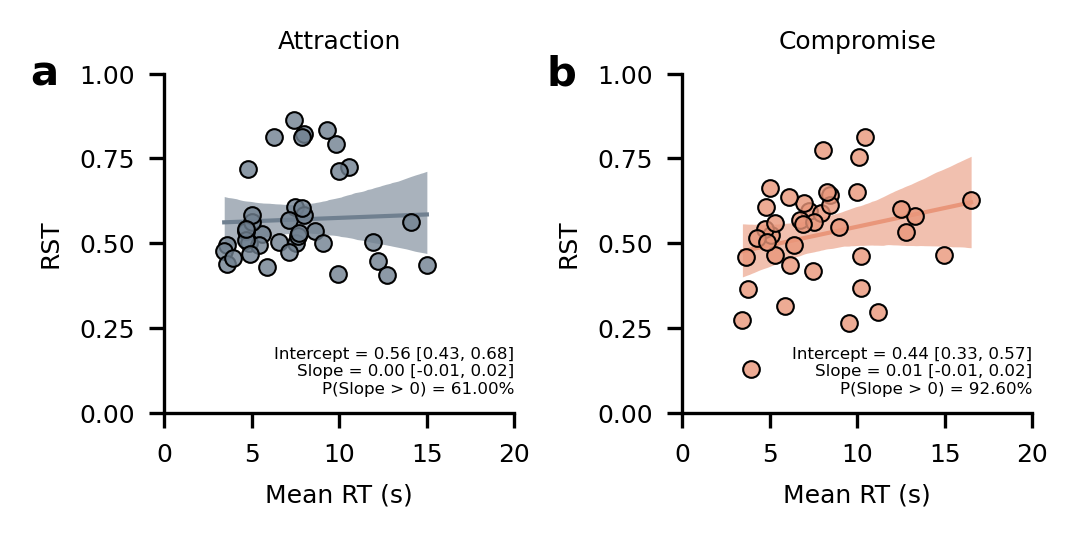

In [46]:
output = {}
fig, axs = plt.subplots(1, 2, figsize=(plotting.plot_utils.cm2inch((9, 4.5))))

colors = ["slategray", "darksalmon"]

for e, (effect, ax) in enumerate(zip(["attraction", "compromise"], axs)):
    print(effect.capitalize() + " trials")
    df_e = df.loc[df["effect"] == effect]

    output = plotting.plot_share.lm(
        x=df_e["mean_rt"],
        y=df_e["rst"],
        ax=ax,
        scatter_color=colors[e],
        line_color=colors[e],
        sample_kwargs={"cores": 1, "random_seed": 44},
    )
    ax, trace, summary = output

    summary.loc["x", "P>0"] = np.mean(trace.get_values("x") > 0)

    stat_str = (
        f"Intercept = {summary.loc['Intercept', 'mean']:.2f} [{summary.loc['Intercept', 'hdi_2.5%']:.2f}, {summary.loc['Intercept', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Slope = {summary.loc['x', 'mean']:.2f} [{summary.loc['x', 'hdi_2.5%']:.2f}, {summary.loc['x', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"P(Slope > 0) = {100 * summary.loc['x', 'P>0']:.2f}%"
    )
    ax.annotate(
        stat_str,
        [1.0, 0.05],
        ha="right",
        va="bottom",
        fontsize=4,
        xycoords="axes fraction",
    )

    # Labels and limits
    ax.set_xlabel(r"Mean RT (s)")
    ax.set_ylabel("RST")
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xlim(0, 20)
    ax.set_title(effect.capitalize())

fig.tight_layout()

# Label panels
for ax, label in zip(axs, list(ascii_lowercase)):
    # Place axis labels in figure space, so that they are aligned
    # https://stackoverflow.com/a/52309638
    xshift = 0.1
    X = ax.get_position().x0
    Y = ax.get_position().y1
    fig.text(X - xshift, Y, label, size=10, weight="bold", ha="right", va="center")

There was no association between individuals' mean response times and context effect strengths. A positive trend of this association was present for compromise trials.

## 4.1 Individual level

Similar to the question whether longer dwell to decoy is associated with larger RST, we can ask, whether individuals were more likely to choose the target in trials with longer RT.

In [47]:
# Add median dwell decoy for each subject and effect
trials = trials.merge(
    trials.groupby(["subject", "effect"], as_index=False)["rt"]
    .quantile(0.5)
    .rename({"rt": "median_rt"}, axis=1),
    on=["subject", "effect"],
)
trials["rt_split"] = np.where(trials["rt"] <= trials["median_rt"], "short", "long")
trials["target_chosen"] = trials["choice_tcd"] == "target"
trials.head()

,subject,block,trial,effect,target,key,choice,choice_tcd,rt,pA,...,dwell_Cm,dwell_total,dwell_target,dwell_competitor,dwell_decoy,median_dwell_decoy,dwell_decoy_split,target_chosen,median_rt,rt_split
0,0,1,1,attraction,A,M,A,target,7220.0,0.78,...,0.091194,5296.395,0.566120,0.190129,0.243751,0.320022,short,True,9440.0,short
1,0,1,2,attraction,B,M,B,target,7770.0,0.78,...,0.055725,6873.000,0.484941,0.295650,0.219409,0.320022,short,True,9440.0,short
2,0,1,3,attraction,A,M,C,decoy,5870.0,0.72,...,0.068932,4991.041,0.293726,0.363652,0.342622,0.320022,long,False,9440.0,short
3,0,1,4,attraction,B,L,C,decoy,9550.0,0.78,...,0.198053,8444.449,0.390671,0.189474,0.419856,0.320022,long,False,9440.0,long
4,0,1,17,attraction,B,M,C,decoy,6430.0,0.72,...,0.238377,5356.978,0.416466,0.208326,0.375207,0.320022,long,False,9440.0,short


In [49]:
subject_means = (
    trials.loc[trials["effect"].isin(["attraction", "compromise"])]
    .groupby(["subject", "effect", "rt_split"], as_index=False)["target_chosen"]
    .mean()
    .pivot_table(
        index=["subject", "effect"], values="target_chosen", columns="rt_split"
    )
    .reset_index()
)
subject_means.head()

rt_split,subject,effect,long,short
0,0,attraction,0.791667,0.729167
1,0,compromise,0.520833,0.625000
2,1,attraction,0.541667,0.500000
3,1,compromise,0.333333,0.145833
4,2,attraction,0.520833,0.479167


In [50]:
subject_means.groupby("effect").mean()

rt_split,subject,long,short
effect,,,
attraction,20.6,0.576300,0.548122
compromise,20.6,0.412265,0.375906


In [51]:
for e, effect in enumerate(["attraction", "compromise"]):
    print(effect.capitalize())

    df_e = subject_means.loc[subject_means["effect"] == effect]

    trace = analysis.best.runBEST1G(
        df_e["long"] - df_e["short"],
        mu=0,
        sigma_low=0.0001,
        sample_kwargs={"cores": 1, "random_seed": 56},
    )

    summary_df = pm.summary(trace, hdi_prob=0.95)
    for var in ["mean", "difference", "d"]:
        summary_df.loc[var, "p>0"] = np.mean(trace.get_values(var) > 0)

    print(
        f"\tmean difference = {summary_df.loc['difference', 'mean']} [{summary_df.loc['difference', 'hdi_97.5%']}, {summary_df.loc['difference', 'hdi_2.5%']}]"
    )
    print(
        f"\td = {summary_df.loc['d', 'mean']} [{summary_df.loc['d', 'hdi_2.5%']}, {summary_df.loc['d', 'hdi_97.5%']}]"
    )

    print(
        "\t{}% of posterior mass above 0.".format(
            100 * np.mean(trace.get_values("d") > 0)
        )
    )

Attraction


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = 0.027 [0.075, -0.02]
	d = 0.186 [-0.12, 0.511]
	86.8% of posterior mass above 0.
Compromise


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = 0.038 [0.075, -0.0]
	d = 0.325 [-0.004, 0.633]
	97.89999999999999% of posterior mass above 0.


Participants were slightly more likely to choose the target in trials with longer RT, but not statistically meaningful. A positive trend of this effect was present for compromise trials.

# 5. Individual best fitting variant mean RST

Table 2 shows the switchboard variants describing most participants best.  
This adds the mean ± s.d. RST for attraction and compromise trials to those.

In [94]:
ind_best_var = pd.read_csv(
    join("..", "results", "4-switchboard", "individual_best-variants_bic.csv"),
    index_col=0,
)
ind_best_var.head()

ind_best_var["model"] = ind_best_var[
    ["integration", "comparison", "gb_alt", "gb_att", "leak", "inhibition"]
].apply(lambda x: "_".join([str(i).replace("_", "-") for i in x]), axis=1)

In [95]:
ind_best_var = ind_best_var.merge(
    cs.pivot_table(values="rst", columns="effect", index="subject"), on="subject"
)

In [103]:
ind_best_var["model"].value_counts().reset_index().rename(
    {"model": "count"}, axis=1
).rename({"index": "model"}, axis=1).merge(
    ind_best_var.groupby("model")
    .head(1)
    .drop(["subject", "bic", "attraction", "compromise"], axis=1),
    on="model",
).merge(
    ind_best_var.groupby("model")[["attraction", "compromise"]].agg(["mean", "std"]),
    on="model",
).round(
    2
).drop(
    "model", axis=1
)

/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,count,integration,comparison,gb_alt,gb_att,leak,inhibition,"(attraction, mean)","(attraction, std)","(compromise, mean)","(compromise, std)"
0,17,multiplicative,n.d.,True,False,free,none,0.51,0.07,0.55,0.08
1,9,multiplicative,vsmean,True,False,free,distance-dependent,0.75,0.12,0.56,0.16
2,4,additive,n.d.,True,False,free,none,0.52,0.05,0.42,0.14
3,3,multiplicative,absolute,False,False,gaze-dependent,none,0.59,0.02,0.54,0.11
4,2,multiplicative,absolute,False,False,free,gaze-dependent,0.50,0.00,0.51,0.20
5,1,multiplicative,vsmean,True,False,gaze-dependent,free,0.51,NaN,0.30,NaN
6,1,multiplicative,vsmean,True,False,gaze-dependent,none,0.43,NaN,0.49,NaN
7,1,multiplicative,vsmean,True,False,free,gaze-dependent,0.47,NaN,0.56,NaN
8,1,multiplicative,absolute,True,True,free,distance-dependent,0.46,NaN,0.13,NaN
9,1,multiplicative,vsmean,True,False,gaze-dependent,distance-dependent,0.72,NaN,0.81,NaN


# 6. Gaze-choice relationship with fixation-count-advantage instead of dwell time advantage

In [143]:
pred_gla = pd.read_csv(
    join(
        "..", "results", "3-behavioural-modeling", "predictions", "predictions_de1.csv"
    )
)
pred_gla = pred_gla.loc[pred_gla["model"] == "glickman1layer"]
pred_gla.head()

,block,choice,choice_tcd,dwell_A,dwell_Am,dwell_Ap,dwell_B,dwell_Bm,dwell_Bp,dwell_C,...,pos_C,predicted_choice,predicted_choiceprob_A,predicted_choiceprob_B,predicted_choiceprob_C,rep,rt,subject,target,trial
2247250,1,0,target,0.566120,0.251566,0.314554,0.190129,0.039272,0.150857,0.243751,...,2,0,0.932697,0.017799,0.049504,0,7220.0,0,A,1
2247251,1,1,target,0.295650,0.224211,0.071439,0.484941,0.329696,0.155245,0.219409,...,2,1,0.068291,0.608959,0.322750,0,7770.0,0,B,2
2247252,1,2,decoy,0.293726,0.165096,0.128630,0.363652,0.130233,0.233418,0.342622,...,1,1,0.070772,0.491992,0.437235,0,5870.0,0,A,3
2247253,1,2,decoy,0.189474,0.093789,0.095684,0.390671,0.238737,0.151934,0.419856,...,0,2,0.056370,0.202794,0.740836,0,9550.0,0,B,4
2247254,1,2,NaN,0.322605,0.322605,0.000000,0.111408,0.111408,0.000000,0.565987,...,1,2,0.006680,0.011117,0.982203,0,3740.0,0,NaN,5


In [144]:
pred_hybrid = pd.read_csv(
    join("..", "results", "4-switchboard", "predictions", "sb_predictions_de1.csv")
)
pred_hybrid = pred_hybrid.loc[
    pred_hybrid["model"]
    == "sb_int-multiplicative_comp-vsmean_gbatt-false_gbalt-true_lk-free_inh-distance-dependent"
]

pred_hybrid = pred_gla.drop(
    [
        "predicted_choice",
        "model",
        "predicted_choiceprob_A",
        "predicted_choiceprob_B",
        "predicted_choiceprob_C",
    ],
    axis=1,
).merge(
    pred_hybrid[["subject", "model", "trial", "predicted_choice", "rep"]],
    on=["subject", "trial", "rep"],
)
pred_hybrid.head()

,block,choice,choice_tcd,dwell_A,dwell_Am,dwell_Ap,dwell_B,dwell_Bm,dwell_Bp,dwell_C,...,pos_A,pos_B,pos_C,rep,rt,subject,target,trial,model,predicted_choice
0,1,0,target,0.566120,0.251566,0.314554,0.190129,0.039272,0.150857,0.243751,...,1,0,2,0,7220.0,0,A,1,sb_int-multiplicative_comp-vsmean_gbatt-false_...,0
1,1,1,target,0.295650,0.224211,0.071439,0.484941,0.329696,0.155245,0.219409,...,0,1,2,0,7770.0,0,B,2,sb_int-multiplicative_comp-vsmean_gbatt-false_...,1
2,1,2,decoy,0.293726,0.165096,0.128630,0.363652,0.130233,0.233418,0.342622,...,2,0,1,0,5870.0,0,A,3,sb_int-multiplicative_comp-vsmean_gbatt-false_...,2
3,1,2,decoy,0.189474,0.093789,0.095684,0.390671,0.238737,0.151934,0.419856,...,2,1,0,0,9550.0,0,B,4,sb_int-multiplicative_comp-vsmean_gbatt-false_...,2
4,1,2,NaN,0.322605,0.322605,0.000000,0.111408,0.111408,0.000000,0.565987,...,0,2,1,0,3740.0,0,NaN,5,sb_int-multiplicative_comp-vsmean_gbatt-false_...,2


In [145]:
predictions = pd.concat([pred_gla, pred_hybrid]).reset_index(drop=True)
predictions = predictions[
    [
        "subject",
        "model",
        "trial",
        "effect",
        "choice",
        "choice_tcd",
        "target",
        "fixated_alternatives",
        "rep",
        "predicted_choice",
    ]
]

# Recode `predicted_choice` variable
predictions["predicted_choice"] = np.array(["A", "B", "C"])[
    predictions["predicted_choice"]
]
# Add `predicted_choice_tcd` variable to predicted data
predictions["predicted_choice_tcd"] = np.where(
    pd.isnull(predictions["target"]),
    np.nan,
    np.where(
        predictions["predicted_choice"] == "C",
        "decoy",
        np.where(
            ((predictions["predicted_choice"] == "A") & (predictions["target"] == "A"))
            | (
                (predictions["predicted_choice"] == "B")
                & (predictions["target"] == "B")
            ),
            "target",
            "competitor",
        ),
    ),
)
del pred_hybrid, pred_gla
predictions.head()

,subject,model,trial,effect,choice,choice_tcd,target,fixated_alternatives,rep,predicted_choice,predicted_choice_tcd
0,0,glickman1layer,1,attraction,0,target,A,[0 0 1 0 2 0 0 0 2 2 0 0 1 1 0 0 0 1 0 0 0 2 0],0,A,target
1,0,glickman1layer,2,attraction,1,target,B,[1 2 1 0 1 0 1 2 2 2 1 1 0 0 0 0 1 1 1 1 2],0,B,target
2,0,glickman1layer,3,attraction,2,decoy,A,[2 1 1 1 1 2 1 1 2 0 0 0 0 2 2 2 0 0 0 2 1 1 1 2],0,B,competitor
3,0,glickman1layer,4,attraction,2,decoy,B,[1 2 2 1 2 1 0 1 0 0 1 2 2 1 0 0 1 2 2 2 2 1 1...,0,C,decoy
4,0,glickman1layer,5,filler,2,NaN,NaN,[0 0 0 2 2 2 0 2 2 1 1 2 2 2],0,C,nan


In [146]:
def count_fixations(fixation_string):
    fixated_alternatives = np.fromstring(fixation_string[1:-1], sep=" ", dtype=int)
    return [np.sum(fixated_alternatives == alt) for alt in [0, 1, 2]]

In [147]:
df = predictions
df[[f"fix_count_{alt}" for alt in [0, 1, 2]]] = pd.DataFrame(
    df["fixated_alternatives"].apply(count_fixations).to_list(),
    columns=[f"fix_count_{alt}" for alt in [0, 1, 2]],
)

df["fix_count_decoy"] = df["fix_count_2"]
df["fix_count_target"] = np.where(
    df["target"] == "A",
    df["fix_count_0"],
    np.where(df["target"] == "B", df["fix_count_1"], np.nan),
)
df["fix_count_competitor"] = np.where(
    df["target"] == "A",
    df["fix_count_1"],
    np.where(df["target"] == "B", df["fix_count_2"], np.nan),
)

df["rel_fix_count_target"] = df["fix_count_target"] - df[
    ["fix_count_competitor", "fix_count_decoy"]
].mean(axis=1)

df["rel_fix_count_target_bin"] = pd.cut(
    df["rel_fix_count_target"], bins=np.arange(-7, 8, 2)
)
del df

In [148]:
predictions.head()

,subject,model,trial,effect,choice,choice_tcd,target,fixated_alternatives,rep,predicted_choice,predicted_choice_tcd,fix_count_0,fix_count_1,fix_count_2,fix_count_decoy,fix_count_target,fix_count_competitor,rel_fix_count_target,rel_fix_count_target_bin
0,0,glickman1layer,1,attraction,0,target,A,[0 0 1 0 2 0 0 0 2 2 0 0 1 1 0 0 0 1 0 0 0 2 0],0,A,target,15,4,4,4,15.0,4.0,11.0,NaN
1,0,glickman1layer,2,attraction,1,target,B,[1 2 1 0 1 0 1 2 2 2 1 1 0 0 0 0 1 1 1 1 2],0,B,target,6,10,5,5,10.0,5.0,5.0,"(3.0, 5.0]"
2,0,glickman1layer,3,attraction,2,decoy,A,[2 1 1 1 1 2 1 1 2 0 0 0 0 2 2 2 0 0 0 2 1 1 1 2],0,B,competitor,7,9,8,8,7.0,9.0,-1.5,"(-3.0, -1.0]"
3,0,glickman1layer,4,attraction,2,decoy,B,[1 2 2 1 2 1 0 1 0 0 1 2 2 1 0 0 1 2 2 2 2 1 1...,0,C,decoy,5,11,12,12,11.0,12.0,-1.0,"(-3.0, -1.0]"
4,0,glickman1layer,5,filler,2,NaN,NaN,[0 0 0 2 2 2 0 2 2 1 1 2 2 2],0,C,nan,4,2,8,8,NaN,NaN,NaN,NaN


In [149]:
predictions.loc[
    (predictions["rep"] == 0) & (predictions["model"] == "glickman1layer"),
    [
        "subject",
        "trial",
        "fix_count_0",
        "fix_count_1",
        "fix_count_2",
        "fix_count_target",
        "fix_count_competitor",
        "fix_count_decoy",
        "rel_fix_count_target",
        "rel_fix_count_target_bin",
    ],
]

,subject,trial,fix_count_0,fix_count_1,fix_count_2,fix_count_target,fix_count_competitor,fix_count_decoy,rel_fix_count_target,rel_fix_count_target_bin
0,0,1,15,4,4,15.0,4.0,4,11.0,NaN
1,0,2,6,10,5,10.0,5.0,5,5.0,"(3.0, 5.0]"
2,0,3,7,9,8,7.0,9.0,8,-1.5,"(-3.0, -1.0]"
3,0,4,5,11,12,11.0,12.0,12,-1.0,"(-3.0, -1.0]"
4,0,5,4,2,8,NaN,NaN,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
438420,43,221,1,5,2,1.0,5.0,2,-2.5,"(-3.0, -1.0]"
438421,43,222,4,3,3,3.0,3.0,3,0.0,"(-1.0, 1.0]"
438422,43,223,1,3,2,3.0,2.0,2,1.0,"(-1.0, 1.0]"
438423,43,224,4,4,1,4.0,4.0,1,1.5,"(1.0, 3.0]"


In [150]:
trials = trials.merge(
    predictions.loc[
        (predictions["rep"] == 0) & (predictions["model"] == "glickman1layer"),
        [
            "subject",
            "trial",
            "fix_count_0",
            "fix_count_1",
            "fix_count_2",
            "fix_count_target",
            "fix_count_competitor",
            "fix_count_decoy",
            "rel_fix_count_target",
            "rel_fix_count_target_bin",
        ],
    ],
    on=["subject", "trial"],
)

In [151]:
predictions.head()

,subject,model,trial,effect,choice,choice_tcd,target,fixated_alternatives,rep,predicted_choice,predicted_choice_tcd,fix_count_0,fix_count_1,fix_count_2,fix_count_decoy,fix_count_target,fix_count_competitor,rel_fix_count_target,rel_fix_count_target_bin
0,0,glickman1layer,1,attraction,0,target,A,[0 0 1 0 2 0 0 0 2 2 0 0 1 1 0 0 0 1 0 0 0 2 0],0,A,target,15,4,4,4,15.0,4.0,11.0,NaN
1,0,glickman1layer,2,attraction,1,target,B,[1 2 1 0 1 0 1 2 2 2 1 1 0 0 0 0 1 1 1 1 2],0,B,target,6,10,5,5,10.0,5.0,5.0,"(3.0, 5.0]"
2,0,glickman1layer,3,attraction,2,decoy,A,[2 1 1 1 1 2 1 1 2 0 0 0 0 2 2 2 0 0 0 2 1 1 1 2],0,B,competitor,7,9,8,8,7.0,9.0,-1.5,"(-3.0, -1.0]"
3,0,glickman1layer,4,attraction,2,decoy,B,[1 2 2 1 2 1 0 1 0 0 1 2 2 1 0 0 1 2 2 2 2 1 1...,0,C,decoy,5,11,12,12,11.0,12.0,-1.0,"(-3.0, -1.0]"
4,0,glickman1layer,5,filler,2,NaN,NaN,[0 0 0 2 2 2 0 2 2 1 1 2 2 2],0,C,nan,4,2,8,8,NaN,NaN,NaN,NaN


In [152]:
trials.head()

,subject,block,trial,effect,target,key,choice,choice_tcd,rt,pA,...,rel_fix_count_target_y,rel_fix_count_target_bin_y,fix_count_0,fix_count_1,fix_count_2,fix_count_target,fix_count_competitor,fix_count_decoy,rel_fix_count_target,rel_fix_count_target_bin
0,0,1,1,attraction,A,M,A,target,7220.0,0.78,...,11.0,NaN,15,4,4,15.0,4.0,4,11.0,NaN
1,0,1,2,attraction,B,M,B,target,7770.0,0.78,...,5.0,"(3.0, 5.0]",6,10,5,10.0,5.0,5,5.0,"(3.0, 5.0]"
2,0,1,3,attraction,A,M,C,decoy,5870.0,0.72,...,-1.5,"(-3.0, -1.0]",7,9,8,7.0,9.0,8,-1.5,"(-3.0, -1.0]"
3,0,1,4,attraction,B,L,C,decoy,9550.0,0.78,...,-1.0,"(-3.0, -1.0]",5,11,12,11.0,12.0,12,-1.0,"(-3.0, -1.0]"
4,0,1,5,filler,NaN,M,C,NaN,3740.0,0.29,...,NaN,NaN,4,2,8,NaN,NaN,8,NaN,NaN


In [158]:
def plot_fix_adv(
    df,
    kind="bar",
    alternative="target",
    ax=None,
    color="C0",
    choicecol="choice_tcd",
    label=None,
    edgecolor=None,
    linewidth=None,
):
    """Make a plot of probability of choice, depending on binned dwell time advantage.

    Args:
        df (pandas.DataFrame): Trial-level dataframe with columns `choicecol`, `total_dwell_adv_{alternative}`
        kind (str, optional): One of ['bar', 'line', 'box']. Defaults to "bar".
        alternative (str, optional): Which alternative (value of `choicecol`) to plot. Defaults to "A".
        ax (matplotlib.axis, optional): Axis to plot on. Makes a new one if None given.
        color (str, optional): Color for bar or line plot. Defaults to "C0".
        choicecol (str, optional): Column indicating the choice in a trial. Defaults to "choice".
        label ([type], optional): Label for matplotlib.legend. Defaults to None.
        edgecolor ([type], optional): Edgecolor of bar and boxplots. Defaults to None.
        linewidth ([type], optional): Linewidth of bar and lineplots. Defaults to None.

    Returns:
        matplotlib.axis: The axis with a plot on it.
    """
    if ax is None:
        ax = plt.gca()

    # Compute means and sems
    df = df.copy()
    df[f"{alternative}_chosen"] = df[choicecol] == alternative
    summary = (
        df.groupby(["subject", f"rel_fix_count_{alternative}_bin"])[
            f"{alternative}_chosen"
        ]
        .mean()
        .reset_index()
        .groupby(f"rel_fix_count_{alternative}_bin")[f"{alternative}_chosen"]
        .aggregate(["mean", "sem"])
    )
    x = np.arange(len(summary))
    if kind == "bar":
        ax.bar(
            x=x,
            height=summary["mean"],
            color=color,
            label=label,
            edgecolor=edgecolor,
            linewidth=linewidth,
            clip_on=False,
        )
        ax.vlines(
            x=x,
            ymin=summary["mean"] - summary["sem"],
            ymax=summary["mean"] + summary["sem"],
            color="black",
        )
    if kind == "box":
        subject_means = (
            df.groupby(["subject", f"rel_fix_count_{alternative}_bin"])[
                f"{alternative}_chosen"
            ]
            .mean()
            .reset_index()
            .pivot(
                index=["subject"],
                values=f"{alternative}_chosen",
                columns=f"rel_fix_count_{alternative}_bin",
            )
        )

        # Remove NA values and make list of arrays for boxplot
        subject_means_boxplottable = [
            (subject_means[interval]).dropna().values
            for interval in subject_means.columns
        ]

        bplot = ax.boxplot(
            subject_means_boxplottable,
            positions=range(len(subject_means_boxplottable)),
            widths=0.5,
            showcaps=False,
            boxprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5, color=edgecolor),
            whiskerprops=dict(linewidth=0.5),
            flierprops=dict(
                marker="o",
                markersize=2,
                markerfacecolor=color,
                markeredgecolor=edgecolor,
                markeredgewidth=0.25,
                alpha=0.9,
            ),
            patch_artist=True,
            zorder=1,
        )
        for patch in bplot["boxes"]:
            patch.set_facecolor(color)

    elif kind == "line":
        ax.plot(
            x,
            summary["mean"],
            "--o",
            color=color,
            markersize=3,
            markerfacecolor="none",
            label=label,
            zorder=2,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        [int(np.round(interval.mid, 2)) for interval in summary.index], rotation=0
    )
    ax.set_xlabel(f"Rel. fix. count {alternative.capitalize()}")

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_ylabel(f"P(Choose {alternative.capitalize()})")

    return ax, summary

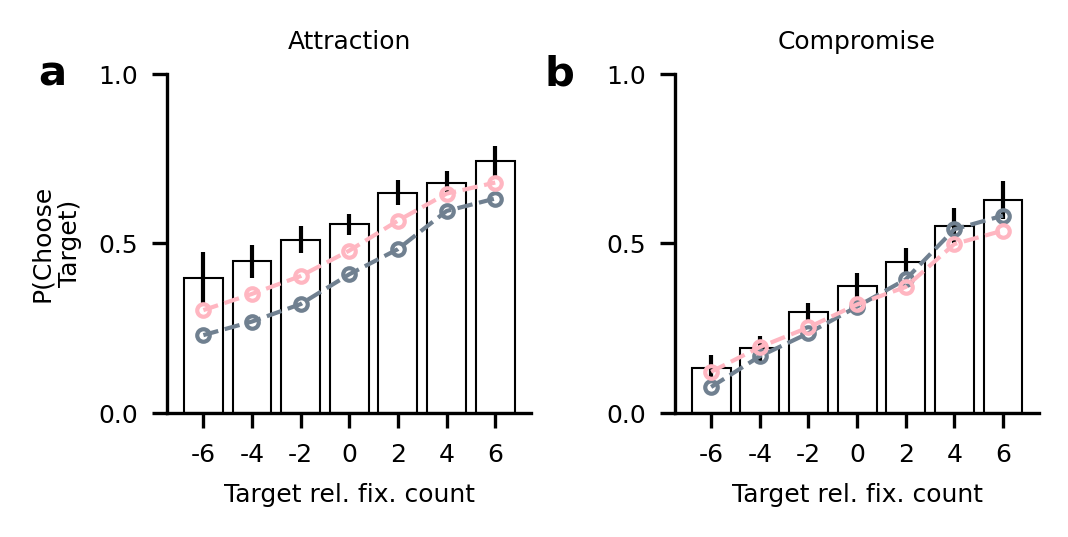

In [159]:
# Gaze advantage prediction
model_labels = {
    "glickman1layer": "GLA",
    "sb_int-multiplicative_comp-vsmean_gbatt-false_gbalt-true_lk-free_inh-distance-dependent": "Hybrid",
}

fig, axs = plt.subplots(1, 2, figsize=plotting.plot_utils.cm2inch(9, 4.5), dpi=300)

for e, effect in enumerate(["attraction", "compromise"]):

    ## Observed data (even trials) as bars
    ax, summary = plot_fix_adv(
        trials.loc[(trials["effect"] == effect) & (trials["trial"] % 2 == 0)],
        kind="bar",
        color="white",
        edgecolor="black",
        linewidth=0.5,
        alternative="target",
        choicecol="choice_tcd",
        ax=axs[e],
    )

    ## Model predictions as lines
    for model, color in zip(
        [
            "glickman1layer",
            "sb_int-multiplicative_comp-vsmean_gbatt-false_gbalt-true_lk-free_inh-distance-dependent",
        ],
        ["slategray", "lightpink"],
    ):
        ax, summary = plot_fix_adv(
            predictions.loc[
                (predictions["model"] == model)
                & (predictions["effect"] == effect)
                & (predictions["trial"] % 2 == 1)
            ],
            kind="line",
            color=color,
            choicecol="predicted_choice_tcd",
            alternative="target",
            label=model_labels[model],
            ax=ax,
        )

    if e == 0:
        ax.set_ylabel("P(Choose\nTarget)")
    else:
        ax.set_ylabel(None)
        ax.yaxis.set_tick_params(labelbottom=True)
    ax.set_xlabel("Target rel. fix. count")
    ax.set_yticks([0, 0.5, 1])
    ax.set_title(effect.capitalize())

fig.tight_layout(h_pad=2, w_pad=3)

# Label panels
for ax, label in zip(axs.ravel(), list(ascii_lowercase)):
    # Place axis labels in figure space, so that they are aligned
    # https://stackoverflow.com/a/52309638
    xshift = 0.095
    X = ax.get_position().x0
    Y = ax.get_position().y1
    fig.text(X - xshift, Y, label, size=10, weight="bold", ha="right", va="center")

# 7. GLA$_{fix.}$ vs. GLA$_{dur.}$

Comparing the reviewer-requested duration-based variant with the fixation-based variant.

In [24]:
# Load GLA_fix estimates
est = pd.read_csv(
    join("..", "results", "3-behavioural-modeling", "estimates", "estimates_de1.csv"),
).drop("Unnamed: 0", axis=1)
gla_fix = (
    est.loc[
        est["model"] == "glickman1layer",
        ["subject", "bic"],
    ]
    .reset_index(drop=True)
    .rename({"bic": "gla_fix"}, axis=1)
)

# Load GLA_fix estimates
gla_dur = pd.read_csv(
    join("..", "results", "S_gla-duration", "model-comparison_bics.csv")
)[["subject", "glickman1layerduration"]].rename(
    {"glickman1layerduration": "gla_dur"}, axis=1
)

df = gla_fix.merge(gla_dur, on="subject")
df["better_variant"] = df[["gla_fix", "gla_dur"]].idxmin(axis=1)
df.head()

,subject,gla_fix,gla_dur,better_variant
0,0,227.499835,264.9905,gla_fix
1,1,275.294884,268.3872,gla_dur
2,2,177.157292,176.4686,gla_dur
3,3,223.646134,227.7920,gla_fix
4,4,343.701224,328.6562,gla_dur


In [25]:
df["better_variant"].value_counts()

gla_fix    29
gla_dur    11
Name: better_variant, dtype: int64

Fixation-based variant was better for 29 of 40 participants.

In [27]:
# Summarise BIC distributions
df[["gla_fix", "gla_dur"]].describe()

,gla_fix,gla_dur
count,40.000000,40.000000
mean,230.628367,240.619548
std,66.796958,65.418073
min,66.870637,79.839100
25%,183.442144,194.247075
50%,236.497144,249.045850
75%,285.308463,289.572300
max,343.701224,356.744800


# 8. Dwell to decoy in attraction vs. compromise trials

In [10]:
dw = pd.read_csv(join("..", "results", "2-gaze", "dwells_across-targets.csv"))
dw.head()

,subject,effect,dwell_A,dwell_B,dwell_C,dwell_p,dwell_m,dwell_target,dwell_competitor,dwell_decoy
0,0,attraction,0.3366,0.3523,0.3111,0.4923,0.5077,0.3818,0.3071,0.3111
1,0,compromise,0.3198,0.3627,0.3175,0.4960,0.5040,0.3651,0.3174,0.3175
2,1,attraction,0.2968,0.3954,0.3079,0.5297,0.4703,0.3508,0.3413,0.3079
3,1,compromise,0.3148,0.3758,0.3094,0.5483,0.4517,0.3471,0.3435,0.3094
4,2,attraction,0.3701,0.3508,0.2791,0.4855,0.5145,0.3507,0.3702,0.2791


In [9]:
dw.groupby("effect")[
    ["dwell_target", "dwell_competitor", "dwell_decoy"]
].describe().T.round(4)

effect                  attraction  compromise
dwell_target     count     40.0000     40.0000
                 mean       0.3616      0.3543
                 std        0.0192      0.0190
                 min        0.3349      0.3053
                 25%        0.3506      0.3450
                 50%        0.3574      0.3566
                 75%        0.3681      0.3692
                 max        0.4233      0.3910
dwell_competitor count     40.0000     40.0000
                 mean       0.3458      0.3322
                 std        0.0241      0.0183
                 min        0.2886      0.3013
                 25%        0.3353      0.3170
                 50%        0.3439      0.3317
                 75%        0.3587      0.3439
                 max        0.3991      0.3828
dwell_decoy      count     40.0000     40.0000
                 mean       0.2927      0.3135
                 std        0.0276      0.0280
                 min        0.2153      0.2463
                 25%        0.2789      0.2983
                 50%        0.2986      0.3122
                 75%        0.3104      0.3334
                 max        0.3498      0.3715

## BEST of relative dwells towards each alternative in attraction vs. compromise trials

In [15]:
for alternative in ["target", "competitor", "decoy"]:
    print(alternative.capitalize())
    
    df = dw[["subject", "effect", f"dwell_{alternative}"]].pivot_table(
        columns="effect", values=f"dwell_{alternative}", index="subject"
    )
    df["difference"] = df["attraction"] - df["compromise"]

    trace = analysis.best.runBEST1G(
        df["difference"],
        mu=0,
        sigma_low=0.0001,
        sample_kwargs={"cores": 1, "random_seed": 1234},
    )

    summary_df = pm.summary(trace, hdi_prob=0.95)
    for var in ["mean", "difference", "d"]:
        summary_df.loc[var, "p>0"] = np.mean(trace.get_values(var) > 0)

    print(
        f"\tmean difference = {summary_df.loc['difference', 'mean']} [{summary_df.loc['difference', 'hdi_97.5%']}, {summary_df.loc['difference', 'hdi_2.5%']}]"
    )
    print(
        f"\td = {summary_df.loc['d', 'mean']} [{summary_df.loc['d', 'hdi_2.5%']}, {summary_df.loc['d', 'hdi_97.5%']}]"
    )

    print(
        "\t{}% of posterior mass above 0.".format(100 * np.mean(trace.get_values("d") > 0))
    )

Target


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = 0.006 [0.015, -0.001]
	d = 0.267 [-0.055, 0.589]
	94.85% of posterior mass above 0.
Competitor


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8907868599671769, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = 0.013 [0.023, 0.005]
	d = 0.523 [0.19, 0.892]
	99.8% of posterior mass above 0.
Decoy


/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_one, sd, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/Users/moltaire/miniconda3/envs/gda-context/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


	mean difference = -0.02 [-0.007, -0.033]
	d = -0.532 [-0.899, -0.202]
	0.15% of posterior mass above 0.
